<a href="https://colab.research.google.com/github/Bandi120424/Sentiment-Anlaysis/blob/main/text%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EA%B0%90%EC%A0%95_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8_by_BERT_230124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 감정 분류 모델 
- 데이터셋: AI-Hub 감정 분류를 위한 음성 데이터셋 

### 라이브러리 임포트

In [1]:
!pip install mxnet #스케일링을 통한 빠른 모델 트레이닝이 가능하며 유연한 프로그래밍 모델과 다수의 프로그래밍 언어를 지원

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install gluonnlp #nlp 분야의 SOTA 모델 implementation을 도와주는 package
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install transformers==4.8.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp38-cp38-linux_x86_64.whl size=689006 sha256=1040fadaaf6dcb07903ed3297c9c93cecde447b580c961e5658cb18dfc226d19
  Stored in directory: /root/.cache/pip/wheels/b6/93/9d/2237550c409eb3ed725d6302b7897ddd9a037b40cef66dcd9c
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-wujsntws
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-wujsntws
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... do

In [ ]:
import pandas as pd
from glob import glob
import os
import gc
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gluonnlp as nlp
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 데이터 로드 및 병합

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
txt_data = pd.read_csv("/new_txt_data_with_data_aug_230124.csv", encoding='utf-8')

In [ ]:
txt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213951 entries, 0 to 213950
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   발화문           213951 non-null  object
 1   final_label   213951 non-null  object
 2   le_sentiment  213951 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [ ]:
print(f"txt_data 길이: {len(txt_data)}")

txt_data 길이: 213951


In [ ]:
txt_data = txt_data.drop(txt_data[txt_data['발화문'].isnull()].index, axis = 0)

In [ ]:
txt_data.head()

,발화문,final_label,le_sentiment
0,느긋해서 이래도 되나 싶어 졸업반이라서 취업을 생각해야 하는데 지금 너무,anxiety,1
1,직업에 대한 질문이 들어왔어 면접에서 부모님,anxiety,1
2,하는 서류가 사라졌어 한 시간 뒤에 제출해야 하는데 어디로 갔지 큰일이야 부장님께 ...,anxiety,1
3,본 회사에서 면접 합격했다고 연락받았었는데 오늘 다시 입사 취소 통보받아서 당혹스러...,anxiety,1
4,가다가 우연히 마주친 동네 아주머니께서 취업했냐고 물어보셔서 당황했어 길을,embrassment,2


#### 결측치 확인

In [ ]:
txt_data.isnull().sum()

발화문             0
final_label     0
le_sentiment    0
dtype: int64

## EDA 

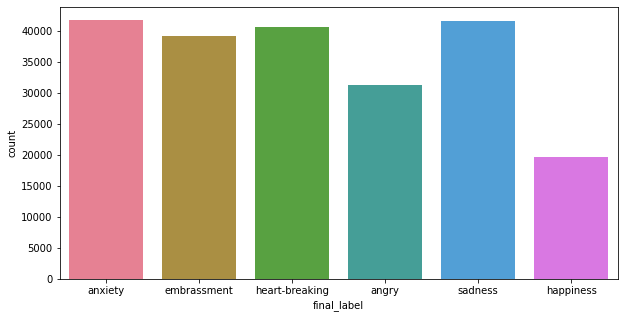

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x = txt_data['final_label'], palette = "husl",  ax = ax)
plt.show()

In [ ]:
# txt_data.to_csv("new_txt_data_with_data_aug_230124.csv", index = False)

### tokenizer

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir = ".cache")

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


범주형 label → 라벨 인코딩

In [ ]:
le = LabelEncoder()
le.fit(txt_data['final_label'].unique())
txt_data['le_sentiment'] = le.transform(txt_data['final_label'])

In [ ]:
final_data = txt_data[['발화문', 'le_sentiment']]

In [ ]:
final_data.head(2)

,발화문,le_sentiment
0,느긋해서 이래도 되나 싶어 졸업반이라서 취업을 생각해야 하는데 지금 너무,1
1,직업에 대한 질문이 들어왔어 면접에서 부모님,1


In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213951 entries, 0 to 213951
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   발화문           213951 non-null  object
 1   le_sentiment  213951 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.0+ MB


## 훈련

### 훈련/테스트 데이터 분리

In [ ]:
tr, test = train_test_split(final_data.values , test_size=0.3, shuffle = True, random_state=0)

In [ ]:
train, val = train_test_split(tr, test_size=0.25, shuffle = True, random_state=0)

### 데이터셋 만들기

In [ ]:
max_len = 80
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                pad, pair, mode = "train"):
        self.mode = mode
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length = max_len, pad = pad, pair = pair)
        if self.mode == "train":
            self.sentences = [transform([i[sent_idx]]) for i in dataset]
            self.labels = [np.int32(i[label_idx]) for i in dataset]
            
        else:
            self.sentences = [transform(i) for i in dataset]
        
    def __getitem__(self, i):
        if self.mode == 'train':
            return (self.sentences[i] + (self.labels[i], ))
        else:
            return self.sentences[i]
    
    def __len__(self):
        return (len(self.sentences))

In [ ]:
data_train = BERTDataset(train, 0, 1, tok, max_len, True, False, mode = "train")
data_valid = BERTDataset(val, 0, 1, tok, max_len, True, False, mode = "train")
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False, mode = "test")

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 모델 만들기

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size = 768, num_classes=6, dr_rate=None, params=None): #클래스 수 조정
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate = 0.3).to(device)

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

### 학습

**Note**

CUDA out of memory

solution 
1. batch size를 줄임
2. GPU의 캐시를 비워줌 
3. ! nivia-smi로 상태확인 kill
4. 좀비 프로세스 종료  
  ! ps -ef | grep python  
  ! kill -9 {process_id}

In [ ]:
#GPU의 캐시를 비워줌
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#model.load_state_dict(torch.load('/content/230124_bert.pth'))

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        train_acc += calc_accuracy(out, label)

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids .long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids) #out: 각 class에 대한 softmax값 
        valid_acc += calc_accuracy(out, label)
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))

100%|██████████| 1756/1756 [24:32<00:00,  1.19it/s]

epoch 1 train acc 0.8286321896355353



100%|██████████| 586/586 [02:58<00:00,  3.29it/s]

epoch 1 valid acc 0.6184673634812287



100%|██████████| 1756/1756 [24:41<00:00,  1.19it/s]

epoch 2 train acc 0.8581114749430524



100%|██████████| 586/586 [02:59<00:00,  3.27it/s]

epoch 2 valid acc 0.6354255546075085



 94%|█████████▍| 1651/1756 [23:07<01:27,  1.20it/s]

In [ ]:
torch.save(model.state_dict(), '230125_bert.pth')

## 추론

In [ ]:
result = []
model.eval()

with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        result.append(model(token_ids, valid_length, segment_ids))

100%|██████████| 1003/1003 [05:07<00:00,  3.27it/s]


In [ ]:
result_ = []
for i in result:
    for j in i:
        result_.append(int(torch.argmax(j)))

In [ ]:
test_label = [np.int32(i[1]) for i in test]

In [ ]:
count = [0 for _ in range(6)]

for i, j in zip(result_, test_label):
  if i == j:
    count[j] += 1

for j in range(6):
  print(f"test_accuracy with label {le.inverse_transform([j])[0]}: {count[j]/test_label.count(j):.2f}")

test_accuracy with label angry: 0.50
test_accuracy with label anxiety: 0.48
test_accuracy with label embrassment: 0.58
test_accuracy with label happiness: 0.79
test_accuracy with label heart-breaking: 0.74
test_accuracy with label sadness: 0.65


In [ ]:
print(f"total test_accuracy: {sum(count)/len(test_label):.2f}")

total test_accuracy: 0.61
